In [ ]:
pip install ISLP

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from ISLP import confusion_table
from ISLP.models import sklearn_sm

from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler, Normalizer, scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, roc_curve
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
df_combats = pd.read_csv('https://raw.githubusercontent.com/Ocrabit/Pokemon-Prediction-Data/main/datasets/combats.csv')
df_pokemon = pd.read_csv('https://raw.githubusercontent.com/Ocrabit/Pokemon-Prediction-Data/main/datasets/pokemon.csv')

In [ ]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [ ]:
df_pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


# Code Below
## [Pokemon Presentation Link](https://www.canva.com/design/DAGDJh8okvQ/kjFWM35OT6cwqR05IxT54w/edit?utm_content=DAGDJh8okvQ&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton)
it has quality slides^^ 🫡🫡🫡🫡

---

## Data Dictionary
df_pokemon:
* '#' --> (Integer) Pokedex Num
* 'Name' --> (String) Name of Pokemon
* 'Type 1' --> (String) 1st Element Type of Pokemon
* 'Type 2' --> (String) 2nd Element Type of Pokemon
* 'HP' --> (Integer) Health Stat
* 'Attack' --> (Integer) Attack Stat
* 'Defense' --> (Integer) Defense Stat
* 'Speed' --> (Integer) Speed Stat
* 'Generation' --> (Integer) Which generation of Pokemon it is in
* 'Legendary' --> (Boolean) If the Pokemon is legendary or not

df_combats:
* 'First_pokemon' --> (Intger) The Pokedex number of the Pokemon who has the initial move in the battle
* 'Second_pokemon' --> (Intger) The Pokedex number of the Pokemon who defends first
* 'Winner' --> (Integer) The Pokedex number of the Pokemon who wins the battle
* 'WinnerBinary' --> (Boolean/Integer) Only contains 0 or 1s. A column added later in the code, when we convert the 'Winner' column into a (0 or a 1) which is read as (False or True). If the pokemon with the initial turn wins it is marked as a 1 else it is marked as a 0

---
# Enjoy The Project

In [ ]:
#My beginning cleaning task is to select only numerical data from the pokemon set
#['#', 'HP', 'Attack', 'Defense', 'Sp. Atk','Sp. Def', 'Speed']
df_stats = df_pokemon[['#', 'HP', 'Attack', 'Defense', 'Sp. Atk','Sp. Def', 'Speed', 'Legendary']]
df_stats.head()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,45,49,49,65,65,45,False
1,2,60,62,63,80,80,60,False
2,3,80,82,83,100,100,80,False
3,4,80,100,123,122,120,80,False
4,5,39,52,43,60,50,65,False


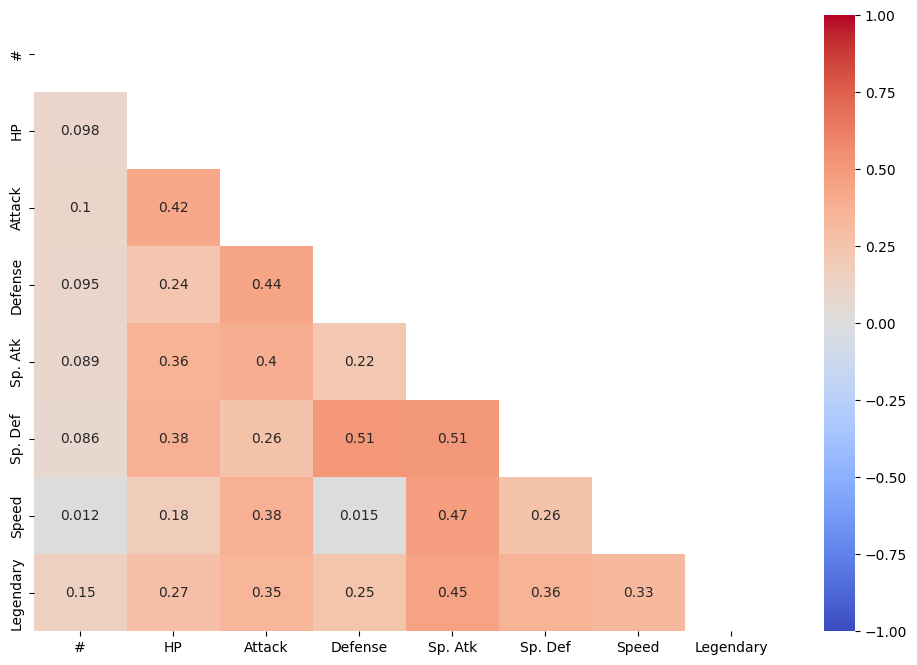

In [ ]:
#heatmap of numerical and boolean information in the pokemon dataset
mask = np.triu(df_stats.corr())
plt.figure(figsize=(12, 8))
sns.heatmap(df_stats.corr(), annot = True, mask=mask, cmap = 'coolwarm', vmin = -1, vmax = 1)
plt.show()

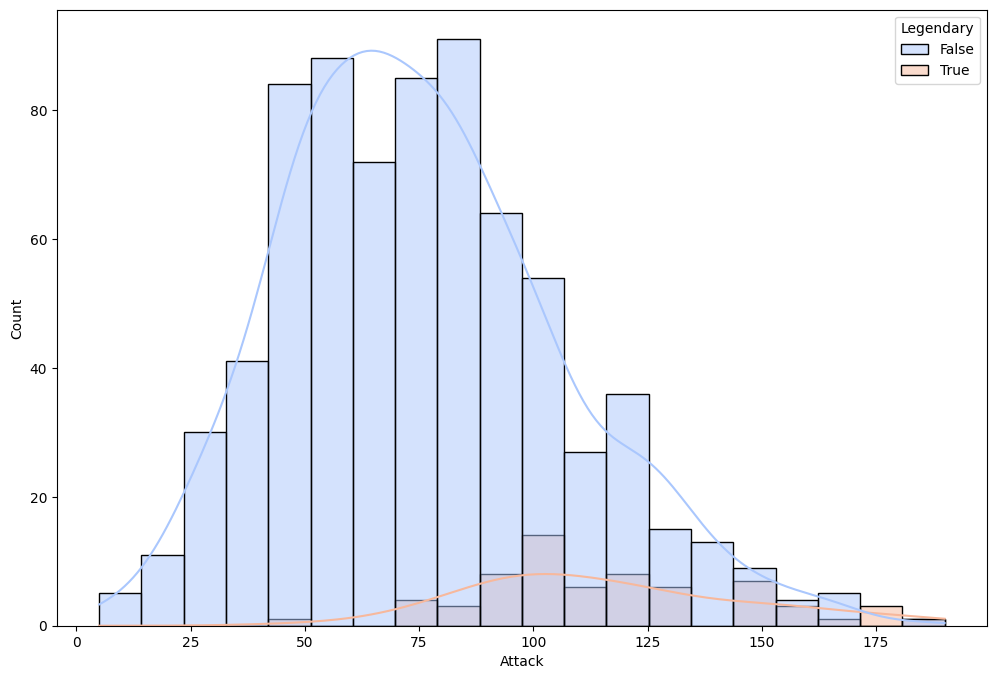

In [ ]:
#Graph looking at the distribution of legendary pokemon in comparison to the regular pokemon's dist.
plt.figure(figsize=(12, 8))
sns.histplot(data=df_pokemon, x='Attack', hue='Legendary', palette='coolwarm', bins=20, kde = True)
plt.show()

Now our first qualitative problem:
What pokemon fall under the legendary status category based on their stats?

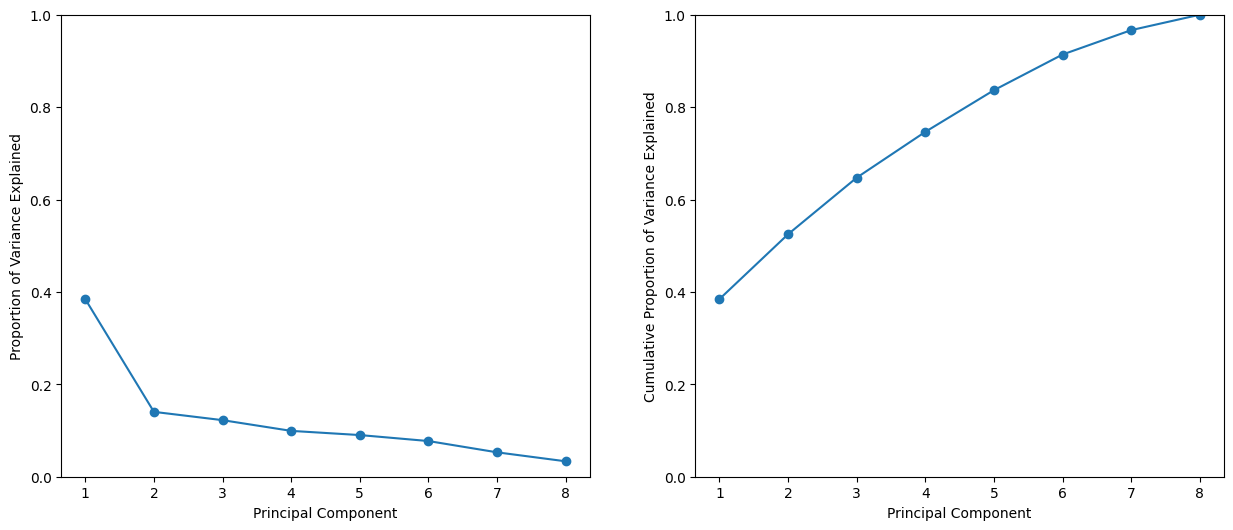

In [ ]:
#Scale the data
scaler = StandardScaler(with_std = True, with_mean = True)
df_scaled = scaler.fit_transform(df_stats)

#Build PCA
#The PCA provides a distinct separation between legendary and regular pokemon groups
pca = PCA()
pca.fit(df_scaled)
scores = pca.transform(df_scaled)

PC1_scores = scores.T[0]
PC2_scores = scores.T[1]

#Show PCA Component Analysis Explained Variance | All components will be useful
fig, axes = plt.subplots(1,2,figsize=(15,6))
ticks = np.arange(pca.n_components_)+1
ax = axes[0]
ax.plot(ticks,pca.explained_variance_ratio_, marker = 'o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

ax = axes[1]
ax.plot(ticks, pca.explained_variance_ratio_.cumsum(),marker='o')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative Proportion of Variance Explained')
ax.set_ylim([0,1])
ax.set_xticks(ticks)

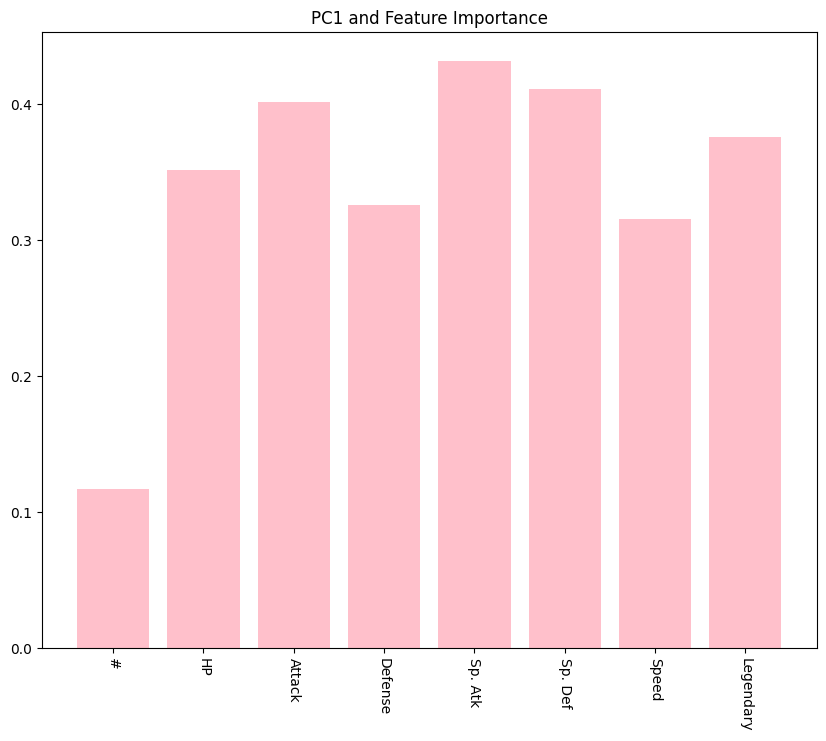

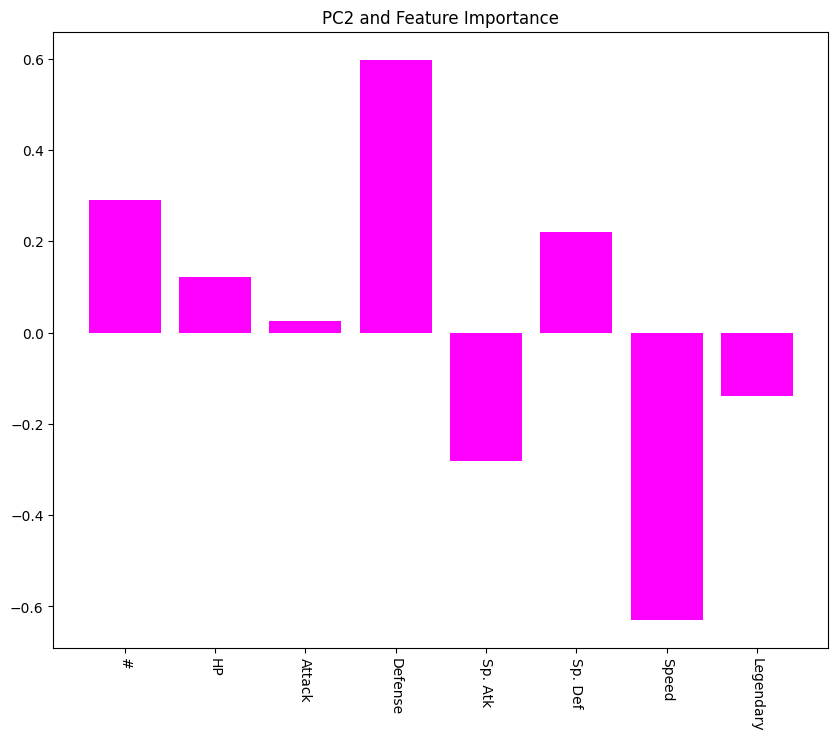

In [ ]:
#Display feature importance for PCA 1 and 2
plt.figure(figsize=(10,8))
ax = axes[0]
ax = plt.bar(height = pca.components_[0], x = df_stats.columns, color = 'pink')
ax = plt.xticks(rotation=-90)
ax = plt.title('PC1 and Feature Importance')
plt.show()

plt.figure(figsize=(10,8))
ax2 = fig.add_subplot(1,2,2)
ax2 = axes[1]
ax2 = plt.bar(height = pca.components_[1], x = df_stats.columns, color = 'magenta')
ax2 = plt.xticks(rotation=-90)
ax2 = plt.title('PC2 and Feature Importance')
plt.show()

The feature importance is actually really cool when we think about it in this scenario because if we follow attacks importance it is rather important in the initial PC1 but when we look at it in PC2 it loses almost all importance. This is because the way that PCA transforms the data. Attacks importance is matched by PC2s orthogonalness to PC1 which shows the data being rotated on top of attack's axis. Anyways all features are important although some are more important then others. Well '#' is just in there so I know what pokemone is what but it is the exception it is not important except from a perspective of viewing things.

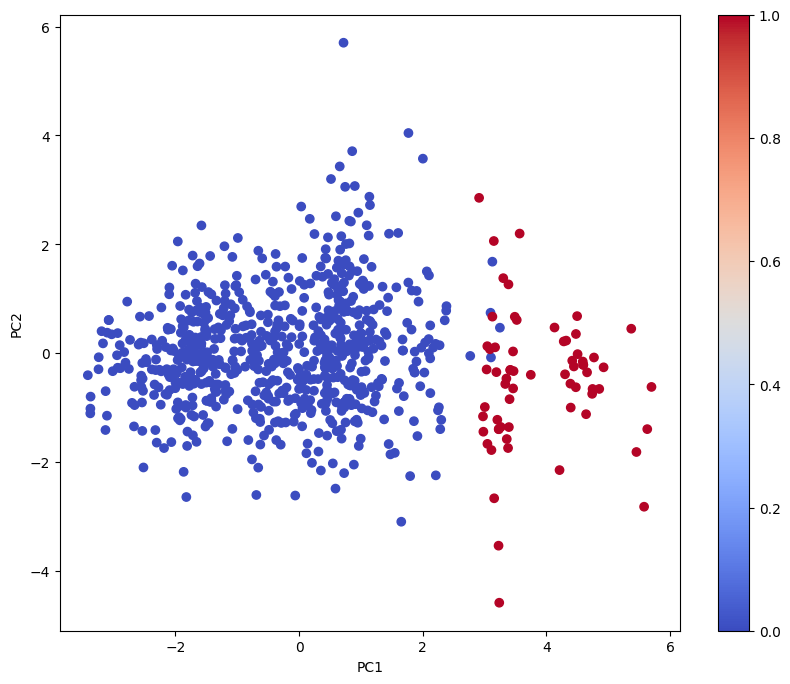

In [ ]:
#Plot PCA 1 and 2 and add a Colormap to show speration between legendary and regular status
PC1_scores = scores.T[0]
PC2_scores = scores.T[1]

plt.figure(figsize=(10,8))
plt.scatter(PC1_scores, PC2_scores, c = df_stats['Legendary'], cmap = 'coolwarm')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()

Logistic Part | 1st Qualitative

In [ ]:
#Build a logistic model to determine Legendary Status
X, Y = df_stats.drop(columns = ['Legendary','#']), df_stats['Legendary']

scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X)
X_scale = scaler.transform(X)

(X_train,
 X_test,
 y_train,
 y_test) = train_test_split(np.asarray(X_scale),
                            Y,
                            test_size=0.3)

glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

summarize(results)

,coef,std err,z,P>|z|
x1,0.2127,0.117,1.813,0.070
x2,0.1805,0.126,1.433,0.152
x3,0.0406,0.117,0.348,0.728
x4,0.1719,0.116,1.476,0.140
x5,0.1440,0.122,1.180,0.238
x6,0.1857,0.107,1.729,0.084


In [ ]:
#Create a confusion matrix for legendary status guessed
labels = np.zeros(len(y_test))
labels[probs>0.5] = 1 #0.67 is a nice value though
con = confusion_table(labels, y_test)
print(confusion_table(labels, y_test))

print('\nAccuracy Score:',accuracy_score(labels,y_test))

#Sensitivity based on Up column
print("\nSensitivity: ", con[1][1]/(con[1][1]+con[1][0]))

#Specificity based on Down column
print("Specificity: ", con[0][0]/(con[0][0]+con[0][1]))

Truth      0.0  1.0
Predicted          
0.0        113    0
1.0        108   19

Accuracy Score: 0.55

Sensitivity:  1.0
Specificity:  0.5113122171945701


Ooo a sexy accuracy score of 0.53, Im drooling, wow. Kidding :). Okay so, the model is extremely focused on sensitivity and not on specificity as the threshold is to low of a number. So lets look at tuning it. ROC and Lasso here we come.

In [ ]:
#Do a cross validation with 5 a subsection of 5 and then do Leave One Out Cross Validation
length_model = sklearn_sm(sm.OLS,
                      MS(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']))

cv_results = cross_validate(length_model, X, Y, cv = 5)

LOOCV_results = cross_validate(length_model, X, Y, cv = len(X))

print('cv_results: ',cv_results['test_score'].mean())
print('LOOCV_results: ',LOOCV_results['test_score'].mean())

#I used both cross validation methods because I could and there wasn't that much data to filter through.
#If I had to choose I would use LOOCV

cv_results:  0.05865552451892977
LOOCV_results:  0.056071398976373234


AUC Score 0.755656108597285


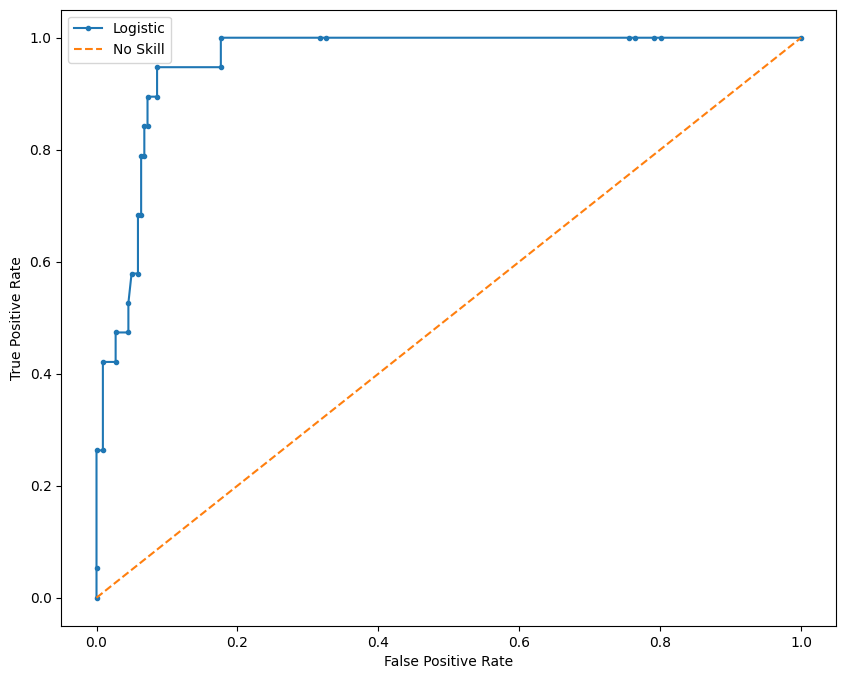

In [ ]:
#Roc curve to look at tuning the parameter
ns_probs = np.ones(len(labels)) #as long as we do better than this we feel good about ourselves

lr_auc = roc_auc_score(y_test, labels)
print("AUC Score", lr_auc)

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(10,8))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
#Lasso | tune
alphas = 10**np.linspace(10,-2,100)*0.5

lasso = Lasso(max_iter = 10000)
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(X_scale, Y)

best_alpha=lassocv.alpha_
print("Best Alpha: ", best_alpha)

lasso.set_params(alpha=best_alpha)
lasso.fit(X_train, y_train)
print("Best MSE: ", mean_squared_error(y_test, lasso.predict(X_test)))

Best Alpha:  0.005
Best MSE:  0.053750776878480414


### Now to the quantitative issue: What is the attack value of the pokemon based on the other given stats?

In [ ]:
#Lets make a least squares line
X = df_stats.drop(['Attack', 'Legendary', '#'], axis=1)
y = df_stats['Attack']

X_train, X_test, y_train, y_test= train_test_split(X,y,
                                                   random_state=42, test_size=0.2)

model = sm.OLS(y_train, X_train)
results = model.fit()

ypred = results.predict(X_test)
print('\nMSE:', mean_squared_error(y_test, ypred))
print('r^2: ', results.rsquared)

summarize(results)


MSE: 616.1027920177248
r^2:  0.9196311344310505


,coef,std err,t,P>|t|
HP,0.3850,0.038,10.066,0.000
Defense,0.5006,0.034,14.685,0.000
Sp. Atk,0.1272,0.038,3.316,0.001
Sp. Def,-0.2797,0.046,-6.036,0.000
Speed,0.3830,0.034,11.169,0.000


An r^2 value of 0.92 thats honestly pretty good. All our features have importance in predicting attack score.

Scatter Plot: oh yeah

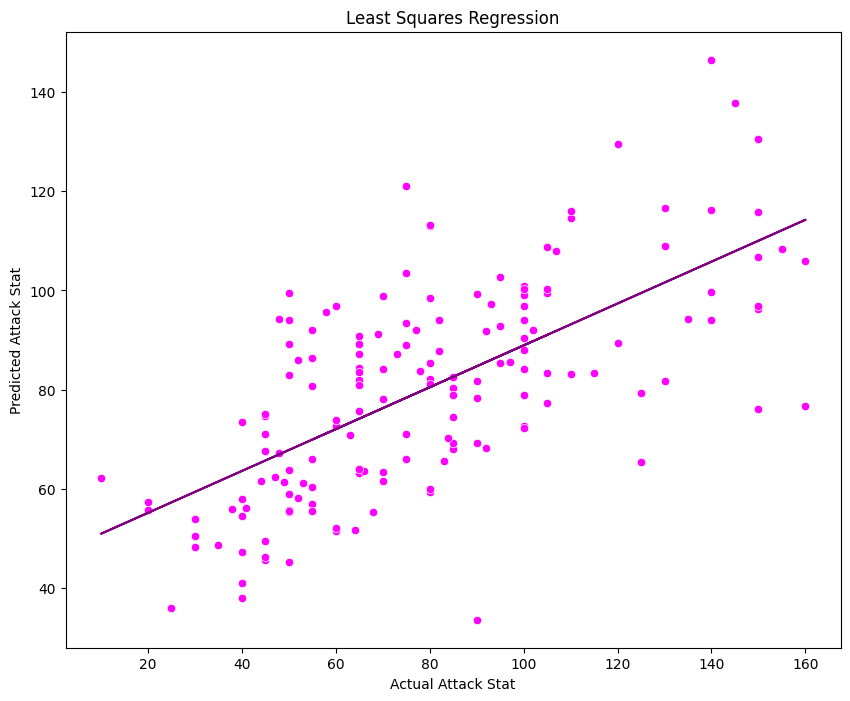

In [ ]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=y_test, y=ypred, c = 'magenta')
plt.xlabel('Actual Attack Stat')
plt.ylabel('Predicted Attack Stat')
plt.title("Least Squares Regression")

# Add the best fit line
z = np.polyfit(y_test, ypred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='purple')

plt.show()

### Lastly now a fun qualitative problem in the project but not really needed: What pokemon will win when two are match against each other?

In [ ]:
def pokemon2id(name):
    num=df_pokemon[df_pokemon["Name"]==name]
    return int(num['#'])

def id2pokemon(id):
    name=df_pokemon[df_pokemon["#"]==id]
    return (name['Name'])

#here we define an easy way to convert pokemon to their id number and reverse

In [ ]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [ ]:
#Create a new column that transforms the Winner category to binary results
df_combats['WinnerBinary']=np.where(df_combats['First_pokemon']==df_combats['Winner'],1,0)

In [ ]:
df_combats.head()

,First_pokemon,Second_pokemon,Winner,WinnerBinary
0,266,298,298,0
1,702,701,701,0
2,191,668,668,0
3,237,683,683,0
4,151,231,151,1


In [ ]:
#Show a logistic model without the stats data trying to predict winner
X = df_combats[['First_pokemon', 'Second_pokemon']]
y = df_combats['WinnerBinary']

X_train, X_test, y_train, y_test= train_test_split(X,y,
                                                   random_state=42, test_size=0.2)

model = sm.GLM(y_train, X_train)
results = model.fit()

ypred = results.predict(X_test)
mean_squared_error(y_test, ypred)

0.2818784787714009

In [ ]:
df_merged_1 = pd.merge(df_stats, df_combats, left_on='#', right_on='First_pokemon', how="inner")
df_merged_1.drop(['First_pokemon', 'Second_pokemon', 'Winner'], axis=1, inplace=True)

df_merged_2 = pd.merge(df_combats.drop(['WinnerBinary'], axis=1), df_stats, left_on='Second_pokemon', right_on='#', how="inner")
df_merged_2.drop(['First_pokemon', 'Second_pokemon', 'Winner'], axis=1, inplace=True)

df_merged_2.rename(columns={'#': '#2', 'HP': 'HP2', 'Attack': 'Attack2', 'Defense': 'Defense2', 'Sp. Atk': 'Sp. Atk2', 'Sp. Def': 'Sp. Def2', 'Speed': 'Speed2', 'Legendary': 'Legendary2'}, inplace=True)

df_combined = pd.concat([df_merged_1, df_merged_2], axis=1)

In [ ]:
df_combined.head()

,#,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,WinnerBinary,#2,HP2,Attack2,Defense2,Sp. Atk2,Sp. Def2,Speed2,Legendary2
0,1,45,49,49,65,65,45,False,0,298,70,70,40,60,40,60,False
1,1,45,49,49,65,65,45,False,0,298,70,70,40,60,40,60,False
2,1,45,49,49,65,65,45,False,0,298,70,70,40,60,40,60,False
3,1,45,49,49,65,65,45,False,0,298,70,70,40,60,40,60,False
4,1,45,49,49,65,65,45,False,0,298,70,70,40,60,40,60,False


In [ ]:
#Make Logistic Model
X = df_combined.drop(['WinnerBinary', 'Legendary', 'Legendary2'], axis=1)
y = df_combined['WinnerBinary']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42, test_size=0.2)
glm_train = sm.GLM(y_train,
                   X_train,
                   family=sm.families.Binomial())
results = glm_train.fit()
probs = results.predict(exog=X_test)

#Make Confusion Table
labels = np.zeros(len(y_test))
labels[probs > 0.5] = 1
con = confusion_table(labels, y_test)

print("Accuracy Score:", accuracy_score(labels, y_test))
#Sensitivity based on Up column
print("Sensitivity: ", con[1][1] / (con[1][1] + con[1][0]))

#Specificity based on Down column
print("Specificity: ", con[0][0] / (con[0][0] + con[0][1]), '\n')

print(confusion_table(labels, y_test))

summarize(results)

Accuracy Score: 0.6954
Sensitivity:  0.6771720613287905
Specificity:  0.7115384615384616 

Truth       0.0   1.0
Predicted            
0.0        3774  1516
1.0        1530  3180


,coef,std err,z,P>|z|
#,-0.0005,0.000047,-10.806,0.000
HP,-0.0042,0.001000,-7.956,0.000
Attack,0.0060,0.000000,12.735,0.000
Defense,-0.0042,0.000000,-9.018,0.000
Sp. Atk,-0.0016,0.000000,-3.433,0.001
Sp. Def,-0.0020,0.001000,-3.596,0.000
Speed,0.0326,0.001000,64.351,0.000
#2,-0.0006,0.000048,-12.285,0.000
HP2,-0.0071,0.001000,-13.664,0.000
Attack2,-0.0009,0.000000,-1.910,0.056


In [ ]:
#Lasso
alphas = 10 ** np.linspace(10, -2, 100) * 0.5

lasso = Lasso(max_iter=10000)
lassocv = LassoCV(alphas=alphas, cv=10, max_iter=100000)
lassocv.fit(X_scale, Y)

best_alpha = lassocv.alpha_
print("Lasso: \nBest Alpha: ", best_alpha)

lasso.set_params(alpha=best_alpha)
lasso.fit(X_train, y_train)
print("Best MSE: ", mean_squared_error(y_test, lasso.predict(X_test)))

Lasso: 
Best Alpha:  0.005
Best MSE:  0.18826376372013187


0.694355261433626


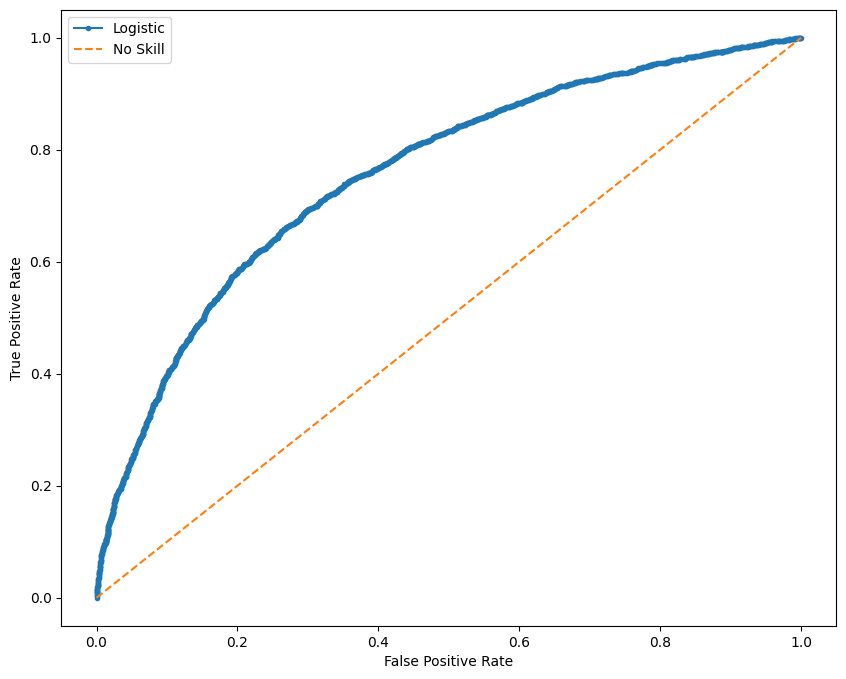

In [ ]:
#ROC Curve
ns_probs = np.ones(len(labels))
#as long as we do better than this we feel good about ourselves

lr_auc = roc_auc_score(y_test, labels)
print(lr_auc)
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)

plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()